In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math
import sys

num_frames = 166
video_imgs = []
readdir = 'D:/44754/Documents/robotics/Perception/RoboticsPerceptionWeek3Code/data/apriltagims/image{:03d}.jpg'
for i in range(num_frames):
    tmp = cv2.imread(readdir.format(i+1))
    video_imgs.append(tmp)
video_imgs = np.array(video_imgs)
print(video_imgs.shape)

(166, 480, 640, 3)


### Pose Estimation
Given the initial corner pixel coordinates, the corner coordinates over time $p_{im}$ are extracted via KLT method. With intrinsic camera parameter matrix $K$ and $p_w$ the cube real world coordinate, homography $H$ can be solved and hence give the rotation $R$ and translation $t$. The homography is of the form,

$$
\begin{align}
Hp_w &\sim p_c = Kp_{im} \\
H &= \lambda 
\begin{pmatrix}
| & | & | \\ r_1 & r_2 & t \\ | & | & | \end{pmatrix}
\end{align}$$

Assuming all the world points lie on $Z=0$, 

\begin{align}
\begin{pmatrix} x_c \\ y_c \\ z_c \end{pmatrix} &= \left[\begin{array}{cc} R & t \end{array} \right]\begin{pmatrix} x_w \\ y_w \\ 0 \\ 1 \end{pmatrix} = \begin{pmatrix} |&|&|&|\\r_1&r_2&r_3&t\\|&|&|&|\end{pmatrix}\begin{pmatrix} x_w \\ y_w \\ 0 \\ 1 \end{pmatrix} \\ 
\Longrightarrow z_c \begin{pmatrix} x_c/z_c \\ y_c/z_c \\ 1 \end{pmatrix} &= \begin{pmatrix} |&|&|\\r_1&r_2&t\\|&|&|\end{pmatrix}\begin{pmatrix} x_w \\ y_w \\ 1 \end{pmatrix} \\ 
\Longrightarrow \begin{pmatrix}x_{im}\\y_{im}\\1\end{pmatrix}  &= \underbrace{\frac{1}{z_c}\begin{pmatrix} |&|&|\\r_1&r_2&t\\|&|&|\end{pmatrix}}_{H}\begin{pmatrix} x_w \\ y_w \\ 1  \end{pmatrix} = \begin{pmatrix} |&|&|\\h_1&h_2&h_3\\|&|&|\end{pmatrix}\begin{pmatrix} x_w \\ y_w \\ 1  \end{pmatrix}
\end{align}

To extract $R$ and $t$ from $H$, assume that there was no noise, then $h_1=\lambda r_1$, $h_2=\lambda r_2$ and $h_3=\lambda t$, for some arbitrary scale factor $\lambda$. Since $r_1$ has norm 1, then $r_1 = \frac{h_1}{\|h_1\|}$, $r_2 = \frac{h_2}{\|h_2\|}$, $r_3 = r_1\times r_2$ and $t = \frac{h_3}{\|h_1\|}$. However, because of noise, $h_1$ and $h_2$ may not be orthogonal and thus not be a rotation matrix. To fix this, SVD is usedm giving estimate of $R$ and $t$, 

\begin{align}
R' &= 
\begin{pmatrix}
|&|&|\\h_1&h_2&(h_1\times h_2)\\|&|&|
\end{pmatrix} = USV^\top \\
R &= 
U\begin{pmatrix}
1&0&0\\0&1&0\\0&0&\det(UV^\top)
\end{pmatrix}V^\top  \\
\end{align}

$R$ and $t$ can now be extracted from $H$,
\begin{align}
R &= 
U\begin{pmatrix}
1&0&0\\0&1&0\\0&0&\det(UV^\top)
\end{pmatrix}V^\top  \\
t &= \frac{h_3}{\|h_1\|}
\end{align}


The above determines the basic algorithm, however, since a homography is only determined up to a scale, there is a sign ambiguity, as if $H$ is negated, the approximate rotation is obtained,

$$R' = 
\begin{pmatrix}
|&|&|\\-h_1&-h_2&(-h_1\times -h_2)\\|&|&|
\end{pmatrix} = \begin{pmatrix}
|&|&|\\-h_1&-h_2&(h_1\times h_2)\\|&|&|
\end{pmatrix}$$

This gives a flip of the $x$ and $y$ axes and thus two valid rotation matrices are available, corresponding to the translations $t$ and $-t$  respectively. To disambiguate this, the code should enforce that the $z$ component of $t$ is positive (i.e. $t_3 = H_{33}>0$ and multiply the $H$ matrix by the appropriate sign to do this. 

### Projecting Points
Once $R$ and $T$ are computed, this can be used to place virtual objects into the world. Given a set of points $X$, project them onto the image, 

\begin{align}
\begin{pmatrix}x_c\\y_c\\z_c\end{pmatrix} &= X_c = K(RX+t) \\
X_{im} &= \frac{X_c}{z_c}
\end{align}

In [2]:
initial_points = 100 * np.array([
   [1.981631469726562,3.165294189453125],
   [3.786268920898438,3.424402770996094],
   [4.036800842285157,1.686005859375000],
   [2.333528289794922,1.491907043457031] ]);
K = 100*np.array([[7.661088867187500,0,3.139585628047498],
                 [0,7.699354248046875,2.503607131410900],
                 [0,0,0.010000000000000]])
pr = np.array([[1,0,0],[0,1,0]])
tag_width = 0.13
tag_height = 0.13
cube_depth = 0.13
print(initial_points.shape)
print(K.shape)

(4, 2)
(3, 3)


In [3]:
def vectorize(r,rp):
    x1=r[0]; x2=r[1]; x3=1
    x1p=rp[0]; x2p=rp[1]
    ax=[-x1,-x2,-1,0,0,0,x1*x1p,x2*x1p,x1p]
    ay=[0,0,0,-x1,-x2,-x3,x1*x2p,x2*x2p,x2p]
    return ax,ay
def est_homography(video_pts,logo_pts):
    A = []
    for i in range(len(logo_pts)):
        r = video_pts[i,:]; rp = logo_pts[i,:]
        ax,ay = vectorize(r,rp)
        A.append(ax)
        A.append(ay)
    A = np.array(A)
    u, s, vh = np.linalg.svd(A, full_matrices=True)
    H = vh[-1,:].reshape((3,3))
    return H

In [4]:
class KLTtrack():
    def __init__(self,imglist,trackpts):
        self.vid = imglist
        self.pts = trackpts
        # Parameters for lucas kanade optical flow
        self.lk_params = dict(winSize  = (31,31),
                  maxLevel = 3,
                  criteria = (cv2.TERM_CRITERIA_EPS|cv2.TERM_CRITERIA_COUNT, 5, 0.03))

    def pointTracker(self):
        # Create some random colors
        color = np.random.randint(0,255,(self.pts.shape[0],3))
        # Take first frame and find corners in it
        old_frame = self.vid[0,:,:,:]
        old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
        p0 = np.floor(self.pts).reshape(-1,1,2).astype(np.float32)
        
        # Create a mask image for drawing purposes
        mask = np.zeros_like(old_frame)
        corners = []
        corners.append(self.pts)

        for i in range(1,num_frames):
            frame = video_imgs[i,:,:,:]
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # calculate optical flow
            p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **self.lk_params)
            # Select good points
            good_new = p1[st==1]
            good_old = p0[st==1]
            # draw the tracks
            for i,(new,old) in enumerate(zip(good_new, good_old)):
                a,b = new.ravel()
                c,d = old.ravel()
                mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
                frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
            img = cv2.add(frame,mask)

            k = cv2.waitKey(5) & 0xff
            if k == 27:
                break
            # Now update the previous frame and previous points
            old_gray = frame_gray.copy()
            corners.append(good_new)
            p0 = good_new.reshape(-1,1,2)
            
        return np.array(corners)

In [5]:
## generate klt images
demo = KLTtrack(video_imgs,initial_points)
corners = demo.pointTracker()

<IPython.core.display.Javascript object>


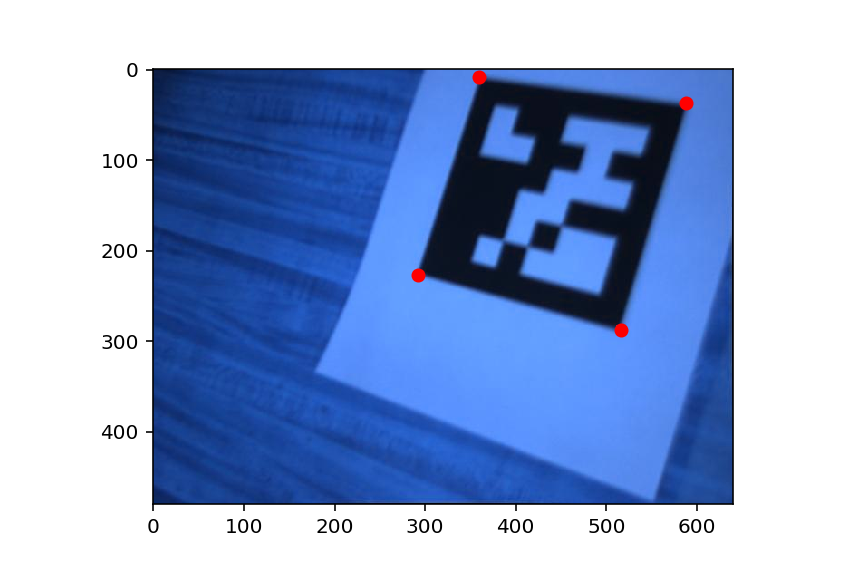

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

fig = plt.figure()
ax = plt.gca()
plt.ion()
fig.show()
fig.canvas.draw()

for i in range(num_frames):
    ax.clear()
    ax.imshow(video_imgs[i,:,:,:])
    ax.plot(corners[i,:,0],corners[i,:,1],'ro')
    fig.canvas.draw()

In [7]:
generated_imgs = []
corner_pts = .5*tag_width*np.array([[1,1],[-1,1],
                                    [-1,-1],[1,-1]])
render_pts1 = np.hstack((corner_pts,np.zeros((4,1))))
render_pts2 = np.hstack((corner_pts,cube_depth*np.ones((4,1))))
render_pts = np.vstack((render_pts1,render_pts2))


In [8]:
def ar_cube(H,render_pts,K):
    H = H*np.sign(H[2,2])
    h1 = H[:,0]; h2 = H[:,1]
    h3 = H[:,2]
    Rp = np.vstack((h1,h2,np.cross(h1,h2))).T
    u, s, vh = np.linalg.svd(Rp, full_matrices=True)
    S = np.diag(np.array([1,1,np.linalg.det(np.matmul(u,vh.T))]))
    R = np.matmul(np.matmul(u,S),vh.T)
    t = h3/np.linalg.norm(h1)
    
    proj_pts = []
    for i in range(len(render_pts)):
        xc = np.matmul(K,np.matmul(R,render_pts[i,:])+t)
        tmppj = xc[0:2].T/xc[-1]
        proj_pts.append(tmppj)
        
    return np.array(proj_pts),t,R

In [9]:
def draw_ar_cube(points,im):
    inds=np.array([0,1,0,3,0,4,1,2,1,5,
                  2,3,2,6,3,7,4,5,4,7,
                  5,6,6,7])
    X = points[inds,:]
    for i in np.arange(0,len(X),2):
        Xj = X[np.array([i,i+1]),:];
        im = cv2.line(tmp,tuple(Xj[0,:].astype(int)),
                   tuple(Xj[1,:].astype(int)),(0,200,200),5)
    return im

<IPython.core.display.Javascript object>


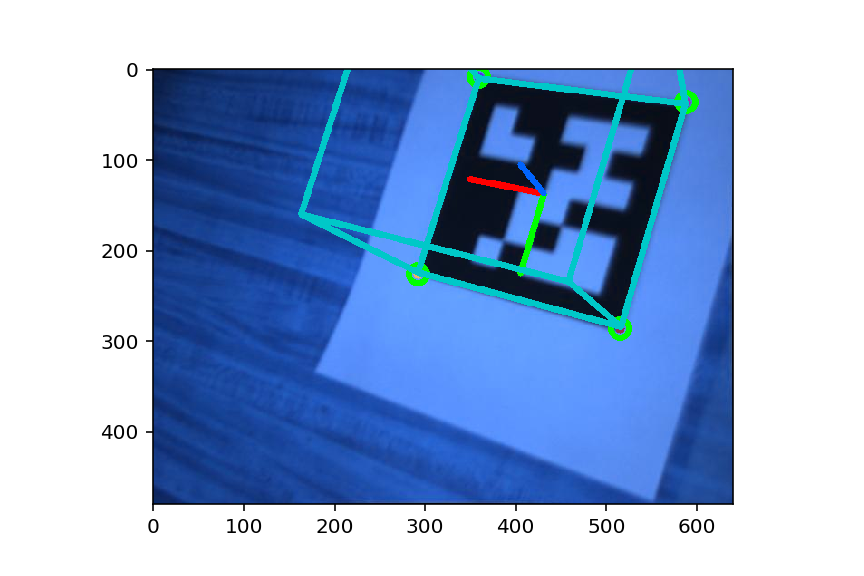

C:\Users\44754\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [10]:
fig = plt.figure()
ax = plt.gca()
plt.ion()
fig.show()
fig.canvas.draw()

generated_imgs = video_imgs.copy()
pos = []; rot = []
for i in range(len(generated_imgs)):
# for i in range(1):
    tmp = generated_imgs[i,:,:,:]
    tmpcorner = corners[i,:,:]
    for j in tmpcorner:
        x,y = np.floor(j.ravel()).astype(int)
        tmp = cv2.circle(tmp,(x,y),10,(0,255,0),5) 
        
    tmp1 = np.vstack((tmpcorner.T,np.ones((1,4))))
    tmp2 = np.array(np.linalg.lstsq(K,tmp1)[0])
    p = np.matmul(pr,tmp2).T
    H = est_homography(corner_pts,p)
    
    proj_pts,tmppos,tmprot = ar_cube(H,render_pts,K)
    pos.append(tmppos)
    rot.append(tmprot)

    frame = .05*np.array([[0,0,0],[1,0,0],[0,1,0],[0,0,1]])
    frame = np.matmul(np.matmul(frame,rot[i].T)+pos[i].T,K.T)
    frame[:,0] = frame[:,0]/frame[:,2]
    frame[:,1] = frame[:,1]/frame[:,2]
    frame = frame[:,0:2]
    
    
    tmp = cv2.line(tmp,tuple(frame[0,:].astype(int)),
                   tuple(frame[1,:].astype(int)),(255,0,0),5)
    tmp = cv2.line(tmp,tuple(frame[0,:].astype(int)),
                   tuple(frame[2,:].astype(int)),(0,255,0),5)
    tmp = cv2.line(tmp,tuple(frame[0,:].astype(int)),
                   tuple(frame[3,:].astype(int)),(0,100,255),5)
    
    tmp = draw_ar_cube(proj_pts,tmp)
    
    ax.clear()
    ax.imshow(tmp)
    fig.canvas.draw()